In [1]:
# This notebook analyzes cookies from crawl NL
# (Run with Python 3.6.1 |Anaconda 4.4.0 )

# Th# This notebook analyzes cookies from crawl NL
# (Run with Python 3.6.1 |Anaconda 4.4.0 )

# The crawl includes 4 vantage points and top 30 websites from NL,BG,DE,US, and 61 from US (no DNT).
# The aim is to understanding cookie-variations well enough to design a good country-cookie-metric.
# (E.g., one site, cookie variations for site based on vantage, and between sites, top-3rd parties, ...)
# (Later, this metric will be linked with site and country characteristics in a regression model.)

%pylab inline --no-import-all 
import pandas as pd
import sqlite3
from numpy import nan
from time import time
from glob import glob
from datetime import datetime
import numpy as np
#from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from tldextract import extract as tldextract  # pip install tldextract
DPI = 120  # used for graphs. check at: http://www.infobyip.com/detectmonitordpi.php

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Two functions that Hadi had to extract domains 

#Function to remove the http, https of site_url
def strip_site(site):
    """Removes leading http:// or https:// and trailing '/'"""
    site = site.lower()
    if site.startswith('http'):
        site = site.replace('https://', '').replace('http://', '')
    if site.endswith('/'):
        site = site[:-1]
    return site

#Function to strip and extract the domains of site_url
def extract_domain(site):
    """Returns domain+tld from a full domain"""
    site = strip_site(site)  # just to be sure
    ext = tldextract(site)
    ret = ".".join([ss for ss in ext[-2:] if ss])
    # In case of gov.ie, or IPs, our 'ret' works better than 'ext.registered_domain'
    return ret

#Function to extract the domains of host
def extract_host(host):
    """Returns domain+tld from a full domain"""
    ext = tldextract(host)
    ret = ".".join([ss for ss in ext[-2:] if ss])
    return ret

#Function to extract the TLD of the websites
def extract_tld(site):
    """Returns domain+tld from a full domain"""
    site = strip_site(site)  # just to be sure
    ext = tldextract(site)
    ret = ".".join([ss for ss in ext[-1:] if ss])
    return ret



### SUCCESS OF THE CRAWL PER VANTAGE POINT

In [3]:
#Read successful crawls

#Connection to the SQLite Database US to create US_S(United States Success) data frame
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-US\\crawl-data.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
US_S=pd.read_sql_query("""SELECT site_url, bool_success 
                    FROM site_visits s 
                    LEFT JOIN CrawlHistory h ON
s.site_url=replace(replace(h.arguments, '[http://]http://', ''), '[https://]https://', '') AND command='GET'                     
""", con)
    
print('crawled US sites',(US_S.site_url.count()))
success=US_S[US_S.bool_success==1].count()['bool_success']
print('success US', success)

#Connection to the SQLite Database NL and doing the query to create NL_S(Netherland Success) data frame
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-NL\\crawl-data.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
NL_S=pd.read_sql_query("""SELECT site_url, bool_success 
                    FROM site_visits s 
                    LEFT JOIN CrawlHistory h ON
s.site_url=replace(replace(h.arguments, '[http://]http://', ''), '[https://]https://', '') AND command='GET'                     
""", con)
    
print('crawled NL sites',(NL_S.site_url.count()))
success=NL_S[NL_S.bool_success==1].count()['bool_success']
print('success NL', success)

#Connection to the SQLite Database DE and doing the query to create DE_S (Germany success) data frame
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-DE\\crawl-data.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
DE_S=pd.read_sql_query("""SELECT site_url, bool_success 
                    FROM site_visits s 
                    LEFT JOIN CrawlHistory h ON
s.site_url=replace(replace(h.arguments, '[http://]http://', ''), '[https://]https://', '') AND command='GET'                     
""", con)

print('crawled DE sites',(DE_S.site_url.count()))
success=DE_S[DE_S.bool_success==1].count()['bool_success']
print('success DE', success)


#Connection to the SQLite Database GB and doing the query to create BG_S (Bulgaria success) data frame
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-GB\\crawl-data.sqlite')
#Query to get all websites and bool_success and add them in a dataframe 
BG_S=pd.read_sql_query("""SELECT site_url, bool_success 
                    FROM site_visits s 
                    LEFT JOIN CrawlHistory h ON
s.site_url=replace(replace(h.arguments, '[http://]http://', ''), '[https://]https://', '') AND command='GET'                     
""", con)
    
print('crawled BG sites',(BG_S.site_url.count()))
success=BG_S[BG_S.bool_success==1].count()['bool_success']
print('success BG', success)




crawled US sites 181
success US 131
crawled NL sites 181
success NL 138
crawled DE sites 181
success DE 132
crawled BG sites 181
success BG 136


### LOADING THE MEASUREMENT DATA/COOKIES 
A data frame per vantage point is created

In [4]:
# Load the measurement data / cookies - VP:US
#Connect to SQLite Database
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-US\\crawl-data.sqlite')
#Query to get all cookies and add them in a dataframe
US=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)
US['VP']='US'
US.head()
#US.shape

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 01:58:20,2018-03-14 01:57:20,US
1,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.930280486.1520992640,0.0,added,2018-03-15 01:57:20,2018-03-14 01:57:20,US
2,http://geoip.hidemyass.com,.hidemyass.com,_ga,GA1.2.1293913234.1520992640,0.0,added,2020-03-13 01:57:20,2018-03-14 01:57:20,US
3,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,en-us,0.0,added,2038-12-31 23:59:59,2018-03-14 01:57:20,US
4,http://geoip.hidemyass.com,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2018-03-14 02:12:21,2018-03-14 01:57:21,US


In [5]:
# Load the measurement data / cookies - VP:NL
#Connect to SQLite Database
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-NL\\crawl-data.sqlite')
#Query to get all cookies and add them in a dataframe
NL=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)
NL['VP']='NL'
NL.head()
#NL.shape

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 00:32:50,2018-03-14 00:31:50,NL
1,http://geoip.hidemyass.com,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2018-03-14 00:46:50,2018-03-14 00:31:50,NL
2,http://geoip.hidemyass.com,.hidemyass.com,_uetsid,_uet07c156d4,0.0,added,2018-03-14 01:01:50,2018-03-14 00:31:50,NL
3,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.975656042.1520987510,0.0,added,2018-03-15 00:31:50,2018-03-14 00:31:50,NL
4,http://geoip.hidemyass.com,.bing.com,MUID,34FCAA0418D266821157A1B61CD265C6,0.0,added,2019-04-08 00:31:50,2018-03-14 00:31:50,NL


In [6]:
# Load the measurement data / cookies - VP: DE
#Connect to SQLite Database
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-DE\\crawl-data.sqlite')
#Query to get all cookies and add them in a dataframe
DE=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)

DE['VP']='DE'
DE.head()
#DE.shape

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.1622646453.1520990095,0.0,added,2018-03-15 01:14:54,2018-03-14 01:14:54,DE
1,http://geoip.hidemyass.com,.hidemyass.com,_ga,GA1.2.2079942532.1520990095,0.0,added,2020-03-13 01:14:54,2018-03-14 01:14:54,DE
2,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,de-de,0.0,added,2038-12-31 23:59:59,2018-03-14 01:14:54,DE
3,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 01:15:55,2018-03-14 01:14:55,DE
4,http://geoip.hidemyass.com,.doubleclick.net,test_cookie,CheckForPermission,0.0,added,2018-03-14 01:29:55,2018-03-14 01:14:55,DE


In [7]:
# Load the measurement data / cookies - BG
#Connect to SQLite Database
con = sqlite3.connect('C:\\Users\\elsar_000\\Desktop\\Thesis\\NewData\\crawl.20180313.2344\\from-GB\\crawl-data.sqlite')
#Query to get all cookies and add them in a dataframe
BG=pd.read_sql_query("""SELECT site_url, host, name, value, is_session, change, expiry, creationTime
                          FROM site_visits s LEFT JOIN javascript_cookies c 
                          ON s.visit_id=c.visit_id ORDER BY s.visit_id""", con)
BG['VP']='BG'
BG.head()


#b_t=BG[(BG.site_url=='http://1und1.de')&(BG.VP=='BG')] #This is to check if the uploaded data is equal to what I had in the DB
#b_t.shape
#BG.shape

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-13 23:45:32,2018-03-13 23:44:32,BG
1,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.1357100759.1520984672,0.0,added,2018-03-14 23:44:32,2018-03-13 23:44:32,BG
2,http://geoip.hidemyass.com,.hidemyass.com,_ga,GA1.2.644153563.1520984672,0.0,added,2020-03-12 23:44:32,2018-03-13 23:44:32,BG
3,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,en-gb,0.0,added,2038-12-31 23:59:59,2018-03-13 23:44:32,BG
4,http://geoip.hidemyass.com,.hidemyass.com,zte2095,1,1.0,added,9999-12-31 23:59:59,2018-03-13 23:44:32,BG


### CLEANING DUPLICATES BEFORE MERGING THE DATA SETS

In [8]:
#Droping cookies duplicated in VP -US
cookies_US_unique=pd.DataFrame(data=US.drop_duplicates(subset=['name','site_url'],keep='last'))
cookies_US_unique.head()
cookies_US_unique.shape

(2643, 9)

In [9]:
#Droping cookies duplicated in NL
cookies_NL_unique=pd.DataFrame(data=NL.drop_duplicates(subset=['name','site_url'], keep='last'))
cookies_NL_unique
#cookies_NL_unique.shape
#cookies_NL_unique.to_csv('cookies_unique_NL.csv', sep=',')

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 00:32:50,2018-03-14 00:31:50,NL
2,http://geoip.hidemyass.com,.hidemyass.com,_uetsid,_uet07c156d4,0.0,added,2018-03-14 01:01:50,2018-03-14 00:31:50,NL
3,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.975656042.1520987510,0.0,added,2018-03-15 00:31:50,2018-03-14 00:31:50,NL
4,http://geoip.hidemyass.com,.bing.com,MUID,34FCAA0418D266821157A1B61CD265C6,0.0,added,2019-04-08 00:31:50,2018-03-14 00:31:50,NL
5,http://geoip.hidemyass.com,bat.bing.com,MUIDB,1521456C898D6E1F39654EDE88816FDA,0.0,added,2019-04-08 00:31:50,2018-03-14 00:31:50,NL
6,http://geoip.hidemyass.com,.hidemyass.com,_ga,GA1.2.536422195.1520987510,0.0,added,2020-03-13 00:31:50,2018-03-14 00:31:50,NL
7,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,en-ww,0.0,added,2038-12-31 23:59:59,2018-03-14 00:31:50,NL
9,http://geoip.hidemyass.com,.zopim.com,__cfduid,dc0c52a0f8cf78587a675be397ca1bac41520987511,0.0,added,2019-03-14 00:31:51,2018-03-14 00:31:51,NL
10,http://geoip.hidemyass.com,.doubleclick.net,IDE,AHWqTUldkQQZQHe7aRFW6Q-uSbrj04UhBkRIC31KhjxM_i...,0.0,added,2019-04-08 00:31:50,2018-03-14 00:31:51,NL
12,http://geoip.hidemyass.com,www.hidemyass.com,_hjIncludedInSample,1,1.0,added,9999-12-31 23:59:59,2018-03-14 00:31:51,NL


In [10]:
#Droping duplicates in DE
cookies_DE_unique=pd.DataFrame(data=DE.drop_duplicates(subset=['name','site_url'],keep='last'))
cookies_DE_unique.head()
#cookies_DE_unique.to_csv('cookies_unique_DE.csv', sep=',')

,site_url,host,name,value,is_session,change,expiry,creationTime,VP
2,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,de-de,0.0,added,2038-12-31 23:59:59,2018-03-14 01:14:54,DE
3,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-14 01:15:55,2018-03-14 01:14:55,DE
5,http://geoip.hidemyass.com,.hidemyass.com,_uetsid,_uet29b9aa1b,0.0,added,2018-03-14 01:44:55,2018-03-14 01:14:55,DE
7,http://geoip.hidemyass.com,.bing.com,MUID,3489EB6262B36F8C25DDE0D066B36CCF,0.0,added,2019-04-08 01:14:55,2018-03-14 01:14:55,DE
8,http://geoip.hidemyass.com,bat.bing.com,MUIDB,02A5345C0F8F636635203FEE0EFD62ED,0.0,added,2019-04-08 01:14:55,2018-03-14 01:14:55,DE


In [11]:
#Droping duplicates in BG 

cookies_BG_unique=pd.DataFrame(data=BG.drop_duplicates(subset=['name','site_url'], keep='last'))
cookies_BG_unique.head()
#cookies_BG_unique.to_csv('cookies_unique_BG.csv', sep=',')
#cookies_BG_unique.shape

#CHEKING 
#n_t=cookies_BG_unique[(cookies_BG_unique.site_url=='http://1und1.de')&(cookies_BG_unique.VP=='BG')]
#n_t.shape



,site_url,host,name,value,is_session,change,expiry,creationTime,VP
0,http://geoip.hidemyass.com,.hidemyass.com,_gat_UA-950416-58,1,0.0,added,2018-03-13 23:45:32,2018-03-13 23:44:32,BG
1,http://geoip.hidemyass.com,.hidemyass.com,_gid,GA1.2.1357100759.1520984672,0.0,added,2018-03-14 23:44:32,2018-03-13 23:44:32,BG
2,http://geoip.hidemyass.com,.hidemyass.com,_ga,GA1.2.644153563.1520984672,0.0,added,2020-03-12 23:44:32,2018-03-13 23:44:32,BG
3,http://geoip.hidemyass.com,www.hidemyass.com,hidemyassComLocale,en-gb,0.0,added,2038-12-31 23:59:59,2018-03-13 23:44:32,BG
6,http://geoip.hidemyass.com,.hidemyass.com,_uetsid,_uet1623de0a,0.0,added,2018-03-14 00:14:33,2018-03-13 23:44:33,BG


In [12]:
#CREATING A SINGLE DATA FRAME WITHOUT DUPLICATES
cookies_unique= pd.concat([cookies_DE_unique, cookies_NL_unique,cookies_US_unique,cookies_BG_unique]).sort_values('site_url')
cookies_unique.head(20)
cookies_unique['TLD']= cookies_unique.site_url.apply(extract_tld)
cookies_unique.head()
#cookies.to_csv('cookies.csv', sep=',')
#cookies_unique.shape

#CHECK
#n_u=cookies_unique[(cookies_unique.site_url=='http://1und1.de')&(cookies_unique.VP=='BG')]
#n_u.shape



,site_url,host,name,value,is_session,change,expiry,creationTime,VP,TLD
1937,http://1und1.de,.1und1.de,_ceg.s,p5k0av,0.0,added,2018-06-14 00:00:00,2018-03-14 00:06:31,BG,de
1895,http://1und1.de,.adfarm1.adition.com,UserID1,6532596586648437395,0.0,changed,2018-09-10 01:51:39,2018-03-14 00:51:08,NL,de
1897,http://1und1.de,.uimserv.net,NGUserID,ac13e487-64717-1520988668-0,0.0,changed,2019-03-14 00:51:13,2018-03-14 00:51:08,NL,de
1899,http://1und1.de,.1und1.de,utag_main,v_id:016221fd42b500142c64e58cc0070004400150090...,0.0,changed,2019-03-14 00:51:14,2018-03-14 00:51:08,NL,de
1900,http://1und1.de,.ioam.de,i00,001e74593c9af892a5aa872010001%3B5aa87202%3B5be...,0.0,changed,2018-11-13 12:01:02,2018-03-14 00:51:13,NL,de


### FILTERING THE DATA >30, DIFFERENT DOMAIN, NO SESSION

In [30]:
#extract the domains to compare them
cookies_unique[["site_url", "host"]] = cookies_unique[["site_url", "host"]].astype(str) 
cookies_unique['site_url']=cookies_unique.site_url.apply(extract_domain)
cookies_unique['host']=cookies_unique.host.apply(extract_host)

#Compare 3rd party domains and the website and leave only the ones that are different
comparison_1pd = cookies_unique["site_url"] == cookies_unique["host"]
cookies_unique['comparison_1pd']=comparison_1pd
cookies_unique = cookies_unique[cookies_unique.comparison_1pd == False]


#convert dates and get only cookies that expire in more than 30 days.
cookies_unique.loc[:,"expiry"] = cookies_unique["expiry"].astype('datetime64[ns]') 
cookies_unique.loc[:,"creationTime"] = cookies_unique["creationTime"].astype('datetime64[ns]')
cookies_unique["timediff"] = cookies_unique.loc[:,"expiry"] - cookies_unique.loc[:,"creationTime"] 

timevar=pd.Timedelta(30,unit='d') #eg. for hours pd.Timedelta(6,unit='h')
cookies_unique=cookies_unique[cookies_unique.timediff>=timevar]

#cookies_unique=cookies_unique[cookies_unique.change!='deleted']

#cookies_unique.dtypes
#cookies_unique


#####CHECK IF AFTER FILTERING I GET THE COOKIES I WANT >=30, DIFFERENT DOMAIN, NO SESSION
#Just to check the count of the values
#x=cookies_unique.is_session.value_counts() #it only remains the non session
#x
#cookies_unique.sort_values('timediff')
#n=cookies_unique[(cookies_unique.site_url=='1und1.de')&(cookies_unique.VP=='BG')]
#n.shape #Chequed with csv 
#n.to_csv('check.csv', sep=',')
#cookies_unique.head(72)

cookies_unique.shape
#cookies_unique.groupby('change').count()

(4365, 12)

In [14]:
#count all unique cookies in each VP
count_unique_cookies=cookies_unique.groupby('VP')['name'].count()
count_unique_cookies

VP
BG    1167
DE     977
NL    1005
US    1216
Name: name, dtype: int64

          Count
VP TLD         
BG co.uk    314
   com      349
   de       331
   nl        91
   us        82
DE co.uk    316
   com      217
   de       277
   nl       100
   us        67
NL co.uk    298
   com      333
   de       259
   nl        54
   us        61
US co.uk    338
   com      397
   de       296
   nl        93
   us        92
            Count
count   20.000000
mean   218.250000
std    121.494585
min     54.000000
25%     91.750000
50%    268.000000
75%    319.750000
max    397.000000


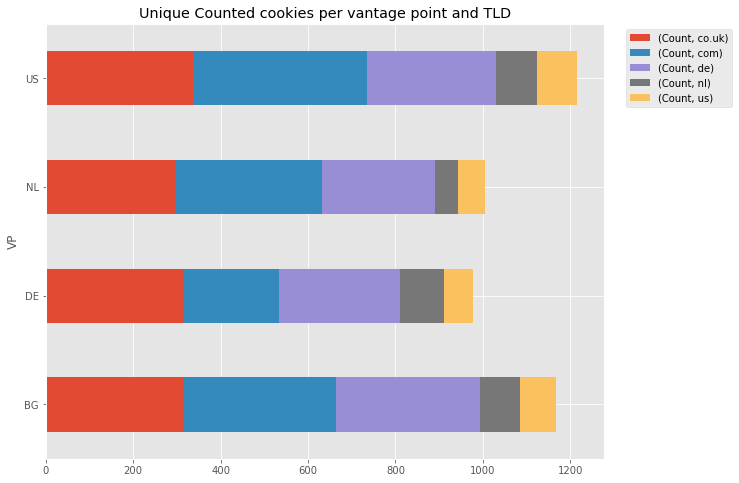

In [15]:
#count unique cookies in each VP per TLD
u_cookies_VP_TLD=cookies_unique.groupby('VP')['TLD'].value_counts().unstack().stack(dropna=False).reset_index(name="Count").set_index(['VP', 'TLD'])
print(u_cookies_VP_TLD)
print(u_cookies_VP_TLD.describe())

#when interpreting this graph keep in mind that .com crawled websites were 61
t1=u_cookies_VP_TLD.unstack().plot.barh(stacked=True,figsize=(10, 8),title='Unique Counted cookies per vantage point and TLD', legend=True)
horiz_offset = 1.03
vert_offset = 1.0
t1.legend(bbox_to_anchor=(horiz_offset, vert_offset))
#plt.savefig('fig',bbox_inches='tight')

In [16]:
#Descriptive stats unique cookies count
cookies_unique.groupby(['VP']).describe()

is_session                                    timediff  \
        count mean  std  min  25%  50%  75%  max    count   
VP                                                          
BG     1167.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1167   
DE      977.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      977   
NL     1005.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1005   
US     1216.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1216   

                                                                           \
                        mean                        std               min   
VP                                                                          
BG  730 days 14:38:49.005998  3631 days 15:02:34.287339  30 days 00:00:00   
DE  773 days 11:42:16.275332  3899 days 18:53:56.416054  30 days 00:00:00   
NL  801 days 23:02:37.029850  3908 days 13:44:02.243639  30 days 00:00:00   
US  745 days 06:59:15.629934  3620 days 01:34:28.651616  30 days 00:00:00   

                                                                    \
                         25%                50%                75%   
VP                                                                   
BG  120 days 00:00:00.500000  365 days 00:00:00  393 days 00:00:00   
DE         180 days 00:00:00  365 days 00:00:00  393 days 00:00:00   
NL          91 days 23:59:56  365 days 00:00:00  395 days 23:00:00   
US         180 days 00:00:00  365 days 00:00:00  396 days 00:00:00   

                         
                    max  
VP                       
BG  99999 days 00:00:00  
DE  99999 days 00:00:00  
NL  99999 days 00:00:00  
US  99999 days 00:00:00

### US Unique Cookies

In [17]:
#Unique cookies- VP US
cookies_US_unique=cookies_unique[cookies_unique.VP=='US'].sort_values(by='site_url')
df_US_unique= pd.DataFrame(data=cookies_US_unique)
#df_US_unique.head()
df_US_unique.shape

(1216, 12)

                    name  VP
site_url                    
microsoft.com         73  US
businessinsider.de    62  US
metro.co.uk           61  US
mathtag.com           59  US
dailymail.co.uk       50  US


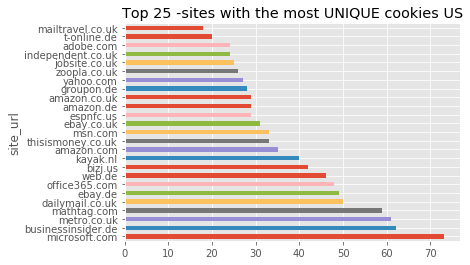

In [18]:
#Websites with more unique cookies -VP: US
u_cookies_US_unique=pd.DataFrame(df_US_unique.groupby('site_url')['name'].count().sort_values(ascending=False))
#print(u_cookies_US_unique.head())
df_US_unique.groupby('site_url')['name'].count().sort_values(ascending=False)[:25].plot(kind='barh',title='Top 25 -sites with the most UNIQUE cookies US')
u_cookies_US_unique['VP']='US'
print(u_cookies_US_unique.head())

### NL Unique Cookies

In [19]:
#Unique cookies- VP NL
cookies_NL_unique=cookies_unique[cookies_unique.VP=='NL'].sort_values(by='site_url')
df_NL_unique= pd.DataFrame(data=cookies_NL_unique)
#df_NL_unique.head()
df_NL_unique.shape

(1005, 12)

                 name  VP
site_url                 
yahoo.com          95  NL
1und1.de           69  NL
dailymail.co.uk    64  NL
mathtag.com        53  NL
t-online.de        51  NL


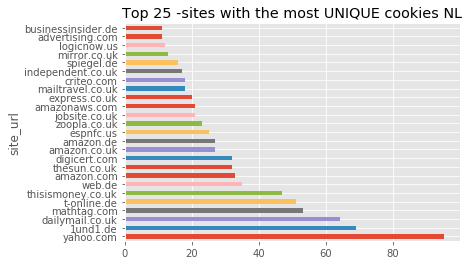

In [20]:
#Websites with more unique cookies -VP: NL
u_cookies_NL_unique=pd.DataFrame(df_NL_unique.groupby('site_url')['name'].count().sort_values(ascending=False))
#print(u_cookies_NL_unique.head())
df_NL_unique.groupby('site_url')['name'].count().sort_values(ascending=False)[:25].plot(kind='barh',title='Top 25 -sites with the most UNIQUE cookies NL')
u_cookies_NL_unique['VP']='NL'
print(u_cookies_NL_unique.head())

### DE Unique cookies


In [21]:
#Unique cookies- VP DE
cookies_DE_unique=cookies_unique[cookies_unique.VP=='DE'].sort_values(by='site_url')
df_DE_unique= pd.DataFrame(data=cookies_DE_unique)
#df_DE_unique.head()
df_DE_unique.shape

(977, 12)

                    name  VP
site_url                    
metro.co.uk           51  DE
dailymail.co.uk       48  DE
businessinsider.de    46  DE
intelliad.de          40  DE
thisismoney.co.uk     40  DE


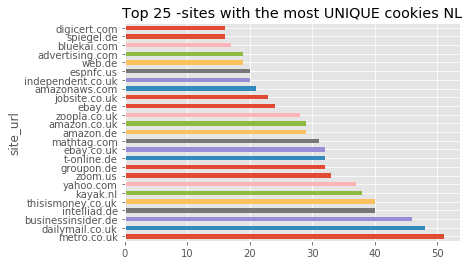

In [22]:
#Websites with more unique cookies -VP: DE
u_cookies_DE_unique=pd.DataFrame(df_DE_unique.groupby('site_url')['name'].count().sort_values(ascending=False))
#print(u_cookies_DE_unique.head())
df_DE_unique.groupby('site_url')['name'].count().sort_values(ascending=False)[:25].plot(kind='barh',title='Top 25 -sites with the most UNIQUE cookies NL')
u_cookies_DE_unique['VP']='DE'
print(u_cookies_DE_unique.head())

### BG Unique cookies

In [23]:
#Unique cookies- VP BG
cookies_BG_unique=cookies_unique[cookies_unique.VP=='BG'].sort_values(by='site_url')
df_BG_unique= pd.DataFrame(data=cookies_BG_unique)
#df_BG_unique.head()
df_BG_unique.shape

(1167, 12)

             name  VP
site_url             
yahoo.com      92  BG
1und1.de       66  BG
ebay.de        49  BG
metro.co.uk    48  BG
mathtag.com    47  BG


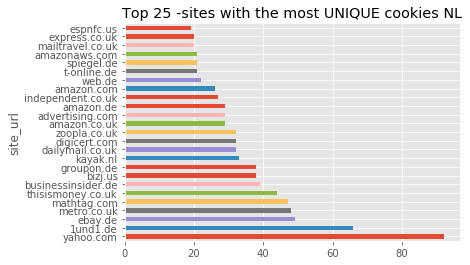

In [24]:
#Websites with more unique cookies -VP: BG
u_cookies_BG_unique=pd.DataFrame(df_BG_unique.groupby('site_url')['name'].count().sort_values(ascending=False))
#print(u_cookies_BG_unique.head())
df_BG_unique.groupby('site_url')['name'].count().sort_values(ascending=False)[:25].plot(kind='barh',title='Top 25 -sites with the most UNIQUE cookies NL')
u_cookies_BG_unique['VP']='BG'
print(u_cookies_BG_unique.head())

### DV UNIQUE COOKIES COUNT

In [25]:
#UNIQUE counted cookies DV
cookiesdv_unique= pd.concat([u_cookies_NL_unique,u_cookies_US_unique,u_cookies_DE_unique,u_cookies_BG_unique]).reset_index()
cookiesdv_unique=cookiesdv_unique.sort_values(by='site_url')
#cookiesdv_unique=cookiesdv_unique.sort_values(by='name',ascending=False)
cookiesdv_unique.head(100)
#cookiesdv_unique.shape 

#check=cookiesdv_count[(cookiesdv_count.site_url=='microsoft.com')]
#check

,site_url,name,VP
1,1und1.de,69,NL
222,1und1.de,7,DE
286,1und1.de,66,BG
118,1und1.de,14,US
153,7gra.us,2,US
351,7gra.us,2,BG
265,7gra.us,2,DE
59,7gra.us,2,NL
154,aaplimg.com,2,US
352,aaplimg.com,2,BG


BG         Axes(0.1,0.559091;0.363636x0.340909)
DE    Axes(0.536364,0.559091;0.363636x0.340909)
NL             Axes(0.1,0.15;0.363636x0.340909)
US        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

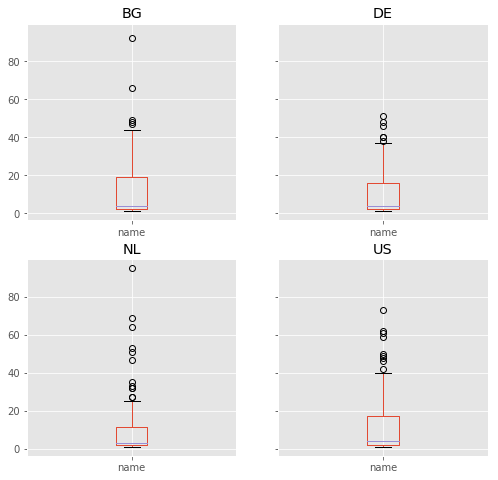

In [26]:
#Boxplot per VP - OUTLIERS are real observations
cookiesdv_unique.groupby('VP').boxplot(figsize=[8,8])

In [27]:
#Descriptive stats Counted cookies - Dependend variable
#There is overdispersion the sdv/mean >1
cookiesdv_unique.groupby('VP').describe()

name                                                  
   count       mean        std  min  25%  50%    75%   max
VP                                                        
BG  96.0  12.156250  16.294221  1.0  2.0  4.0  19.25  92.0
DE  95.0  10.284211  12.939025  1.0  2.0  4.0  16.00  51.0
NL  92.0  10.923913  16.764847  1.0  2.0  3.0  11.25  95.0
US  98.0  12.408163  16.815455  1.0  2.0  4.0  17.25  73.0

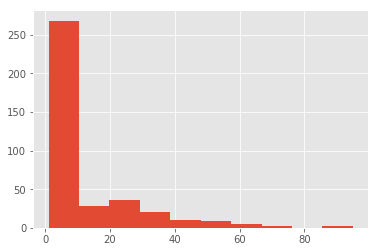

In [28]:
#Histogram of counted cookies - shape of the distribution is skew and non normal - Negative Binomial
#It cannot be poisson because the mean is different form the sd
cookiesdv_unique.name.hist()

In [29]:
x=cookiesdv_unique.name.kurtosis()
print('Kurtosis:', x)
y=cookiesdv_unique.name.skew()
print('Skweness:', y)

Kurtosis: 5.182084987405428
Skweness: 2.149635036678394
